# DA- VAE, Diffusion (HRV past research dataset)

* Using Keras/Tensorflow

In [1]:
import os
import time
# import shap ## for XAI
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
# import pingouin as pg
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

In [140]:
from numpy import dot
from numpy.linalg import norm

from keras.models import Sequential
from keras.layers import Dense , Dropout , Lambda, Flatten
from keras.layers import Dense , Activation, Dropout, BatchNormalization
from keras.optimizers import Adam ,RMSprop
from keras.callbacks import Callback

from scipy.special import rel_entr
from scipy.stats import gaussian_kde
from scipy.spatial.distance import jensenshannon

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, train_test_split, ParameterGrid
from sklearn import decomposition, metrics
from sklearn.cluster import KMeans
from sklearn.metrics import cohen_kappa_score,f1_score, confusion_matrix, roc_auc_score
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import Normalizer, MinMaxScaler
from sklearn.manifold import TSNE

from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Input, Dense, Lambda, Conv1D, Flatten, Reshape, UpSampling1D, MaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.losses import mse, MeanSquaredError

***

---

## Original data check

In [185]:
### In this research, the dataset is breast cancer dataset (tabular format)

data_ori = pd.read_csv('E:/RESEARCH/Datasets/HRV/HRV_samsung/HRV_REV_all.csv')

In [186]:
### data shape, variables check
print("The shape of the HRV dataset is:",data_ori.shape)
# print(public.columns)
data_ori.head()

The shape of the HRV dataset is: (479, 93)


,sub,VISIT,disorder,age,gender,HAMD,HAMA,PDSS,ASI,APPQ,...,cRMSSD,cVLF,cLF,cHF,cLF/HF,cPOWER,cHR,cRESP,cSC,cTEMP
0,E001,4,2,23,1,2,2,1,12,22,...,41.544667,190.107000,298.508333,206.862333,1.284000,695.477333,65.707000,14.054333,3.911333,34.998000
1,E001,5,2,23,1,12,7,0,12,24,...,39.825333,143.756667,115.695333,202.602667,0.585000,462.054667,69.040000,14.117333,6.255000,35.544333
2,E002,1,2,38,1,14,17,14,31,122,...,20.052000,22.006000,50.182000,32.529333,2.499333,104.717000,92.789333,11.013333,0.945667,35.086000
3,E002,2,2,38,1,13,36,16,32,139,...,20.201667,55.579000,84.441000,18.754000,5.803000,158.774333,85.980667,12.608333,0.785667,36.141000
4,E002,3,2,38,1,7,10,11,23,70,...,74.788000,182.229000,530.565667,546.574000,1.685667,1259.368667,84.368667,14.285667,0.648000,35.879000


In [187]:
# data_ori.columns

In [188]:
# 결측값이 하나라도 있는 행의 개수 확인
num_missing_rows = data_ori.isna().any(axis=1).sum()

print(f"The number of rows that contains at least one missing value: {num_missing_rows}")

The number of rows that contains at least one missing value: 0


In [189]:
data_ori.columns

Index(['sub', 'VISIT', 'disorder', 'age', 'gender', 'HAMD', 'HAMA', 'PDSS',
       'ASI', 'APPQ', 'PSWQ', 'SPI', 'PSS', 'BIS', 'SSI', 'b1SDNN', 'b1NN50',
       'b1PNN50', 'b1RMSSD', 'b1VLF', 'b1LF', 'b1HF', 'b1LF/HF', 'b1POWER',
       'b1HR', 'b1RESP', 'b1SC', 'b1TEMP', 'sSDNN', 'sNN50', 'sPNN50',
       'sRMSSD', 'sVLF', 'sLF', 'sHF', 'sLF/HF', 'sPOWER', 'sHR', 'sRESP',
       'sSC', 'sTEMP', 'b2SDNN', 'b2NN50', 'b2PNN50', 'b2RMSSD', 'b2VLF',
       'b2LF', 'b2HF', 'b2LF/HF', 'b2POWER', 'b2HR', 'b2RESP', 'b2SC',
       'b2TEMP', 'rSDNN', 'rNN50', 'rPNN50', 'rRMSSD', 'rVLF', 'rLF', 'rHF',
       'rLF/HF', 'rPOWER', 'rHR', 'rRESP', 'rSC', 'rTEMP', 'b3SDNN', 'b3NN50',
       'b3PNN50', 'b3RMSSD', 'b3VLF', 'b3LF', 'b3HF', 'b3LF/HF', 'b3POWER',
       'b3HR', 'b3RESP', 'b3SC', 'b3TEMP', 'cSDNN', 'cNN50', 'cPNN50',
       'cRMSSD', 'cVLF', 'cLF', 'cHF', 'cLF/HF', 'cPOWER', 'cHR', 'cRESP',
       'cSC', 'cTEMP'],
      dtype='object')

In [199]:
# data_ori['disorder_mdd'] = 0

In [198]:
# ## Categorizing HAMD scores to generate 'disorder_mdd' label variable.
# data_ori.loc[data_ori['HAMD']<7, 'disorder_mdd'] = "normal"
# data_ori.loc[(data_ori['HAMD']>=7) & (data_ori['HAMD']<18), 'disorder_mdd'] = "mild"
# data_ori.loc[data_ori['HAMD']>=18, 'disorder_mdd'] = "mod_severe"

In [ ]:
## Categorizing HAMD scores to generate 'disorder_mdd' label variable.
# data_ori.loc[data_ori['HAMD']<7, 'disorder_mdd'] = "normal"
# data_ori.loc[(data_ori['HAMD']>=7) & (data_ori['HAMD']<18), 'disorder_mdd'] = "mild"
# data_ori.loc[(data_ori['HAMD']>=18) & (data_ori['HAMD']<25), 'disorder_mdd'] = "moderate"
# data_ori.loc[data_ori['HAMD']>=25, 'disorder_mdd'] = "severe"

In [197]:
# data_ori['disorder_mdd'].value_counts()

In [196]:
# data_ori.to_csv('E:/RESEARCH/Datasets/HRV/HRV_samsung/HRV_REV_processed.csv', index=False)

> Target value is "disorder" variable. \
> 1: major depressive disorder, 2: panic disorder, 3: control

In [42]:
data_ori['disorder'] = data_ori['disorder'].replace({1: 'mdd'})
data_ori['disorder'] = data_ori['disorder'].replace({2: 'pd'})
data_ori['disorder'] = data_ori['disorder'].replace({3: 'con'})

In [43]:
info_list = ['sub', 'VISIT', 'age', 'gender', 'disorder']
scale_list = ['HAMD', 'HAMA', 'PDSS', 'ASI', 'APPQ', 'PSWQ', 'SPI', 'PSS', 'BIS', 'SSI']
drop_list = info_list + scale_list

In [44]:
x = data_ori.drop(drop_list, axis=1)
y = data_ori.disorder

In [45]:
y.value_counts()

disorder
con    194
pd     149
mdd    136
Name: count, dtype: int64

In [46]:
x.columns

Index(['b1SDNN', 'b1NN50', 'b1PNN50', 'b1RMSSD', 'b1VLF', 'b1LF', 'b1HF',
       'b1LF/HF', 'b1POWER', 'b1HR', 'b1RESP', 'b1SC', 'b1TEMP', 'sSDNN',
       'sNN50', 'sPNN50', 'sRMSSD', 'sVLF', 'sLF', 'sHF', 'sLF/HF', 'sPOWER',
       'sHR', 'sRESP', 'sSC', 'sTEMP', 'b2SDNN', 'b2NN50', 'b2PNN50',
       'b2RMSSD', 'b2VLF', 'b2LF', 'b2HF', 'b2LF/HF', 'b2POWER', 'b2HR',
       'b2RESP', 'b2SC', 'b2TEMP', 'rSDNN', 'rNN50', 'rPNN50', 'rRMSSD',
       'rVLF', 'rLF', 'rHF', 'rLF/HF', 'rPOWER', 'rHR', 'rRESP', 'rSC',
       'rTEMP', 'b3SDNN', 'b3NN50', 'b3PNN50', 'b3RMSSD', 'b3VLF', 'b3LF',
       'b3HF', 'b3LF/HF', 'b3POWER', 'b3HR', 'b3RESP', 'b3SC', 'b3TEMP',
       'cSDNN', 'cNN50', 'cPNN50', 'cRMSSD', 'cVLF', 'cLF', 'cHF', 'cLF/HF',
       'cPOWER', 'cHR', 'cRESP', 'cSC', 'cTEMP'],
      dtype='object')

--------------

----------

## 1D VAE model

In [33]:
data_ori["disorder"].value_counts()

disorder
con    194
pd     149
mdd    136
Name: count, dtype: int64

In [34]:
data = data_ori

In [35]:
data_con = data[data['disorder']=="con"]
data_pd = data[data['disorder']=="pd"]
data_mdd = data[data['disorder']=="mdd"]

In [ ]:
class Args:
    # arugments
    epochs=100
    bs=32
    lr=0.0001
    momentum=0.9
    num_classes= 2
    latent_dim = 16
    inter_dim1 = 32
    inter_dim2 = 16
    seed=710674

args = Args()

# np.random.seed(args.seed)
# random.seed(args.seed)
# torch.manual_seed(args.seed)

In [ ]:
data_vae = data_ori.copy()
# data_vae = data_B.copy()
# data_vae = data_M.copy()

In [ ]:
# y includes our labels and x includes our features
y = data_vae.diagnosis  # M or B 
list = ['Unnamed: 32','id','diagnosis']
x = data_vae.drop(list, axis = 1 )

In [ ]:
data_x = x.copy()

In [ ]:
scaler = MinMaxScaler() #set the scaler (between 0 and 1)

data_x[:] = scaler.fit_transform(data_x[:])
data_x = data_x.round(decimals=5)

In [ ]:
# data_x = (data_x - np.mean(data_x, axis=0)) / np.std(data_x, axis=0)  # 데이터 정규화

In [ ]:
# data_x.head()

In [ ]:
# # 데이터 확인
# print(np.isnan(data_x).any())  # False여야 합니다.
# print(np.isinf(data_x).any())  # False여야 합니다.

In [ ]:
# data_x = data_x.fillna(data_x.mean())

In [ ]:
### breast cancer wisconsin ####### BINARY CLASSIFICATION ##########

label = y
label = label.replace({'B':0})
label = label.replace({'M': 1})

data_y = to_categorical(label, 2) ## into the format of one-hot encoding

In [ ]:
print("The size of x dataset is:", data_x.shape)
print("The size of y dataset is:", data_y.shape)

### encoder networks

In [ ]:
input_dim = data_x.shape[1]
latent_dim = 2

inputs = Input(shape=(input_dim,))
h = Dense(32, activation='relu')(inputs)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

In [ ]:
# ## deeper model
# input_dim = data_x.shape[1]
# latent_dim = 2  

# inputs = Input(shape=(input_dim,))
# h = Dense(128, activation='relu')(inputs)
# h = Dense(64, activation='relu')(h)
# h = Dense(32, activation='relu')(h)
# z_mean = Dense(latent_dim)(h)
# z_log_var = Dense(latent_dim)(h)

In [ ]:
## latent space sampling
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

### decoder networks

In [ ]:
decoder_h = Dense(32, activation='relu')
decoder_mean = Dense(input_dim, activation='sigmoid')

h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

In [ ]:
# ## deeper model
# decoder_h1 = Dense(32, activation='relu')
# decoder_h2 = Dense(64, activation='relu')
# decoder_h3 = Dense(128, activation='relu')
# decoder_mean = Dense(input_dim, activation='sigmoid')

# h_decoded = decoder_h1(z)
# h_decoded = decoder_h2(h_decoded)
# h_decoded = decoder_h3(h_decoded)
# x_decoded_mean = decoder_mean(h_decoded)

### model define

In [ ]:
vae = Model(inputs, x_decoded_mean)
vae.summary()

### loss function

In [ ]:
reconstruction_loss = MeanSquaredError()(inputs, x_decoded_mean)

kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var + K.epsilon()), axis=-1)
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

In [ ]:
vae.compile(optimizer=Adam(learning_rate=0.001))

In [ ]:
vae.summary()

### model training

In [ ]:
vae.fit(data_x, epochs=args.epochs, batch_size=args.bs, validation_split=0.2, verbose=2)

### extracting encoder, decoder

In [ ]:
## encoder model extraction
encoder = Model(inputs, z_mean)

In [ ]:
## decoder model extraction
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
decoder = Model(decoder_input, _x_decoded_mean)

# #### deeper model
# decoder_input = Input(shape=(latent_dim,))
# _h_decoded = decoder_h1(decoder_input)
# _h_decoded = decoder_h2(_h_decoded)
# _h_decoded = decoder_h3(_h_decoded)
# _x_decoded_mean = decoder_mean(_h_decoded)
# decoder = Model(decoder_input, _x_decoded_mean)

In [ ]:
# # 입력 데이터를 잠재 공간으로 인코딩
# encoded_data = encoder.predict(data_x)

# # 잠재 공간의 데이터를 디코딩하여 원래 공간으로 복원
# decoded_data = decoder.predict(encoded_data)

### Latent space visualization

In [ ]:
## encode the input dataset into latent space
encoded_data = encoder.predict(data_x)

## latent space transform with t-SNE function
tsne = TSNE(n_components=2, random_state=710674)
encoded_data_tsne = tsne.fit_transform(encoded_data)

## visualize
plt.figure(figsize=(8, 6))
plt.scatter(encoded_data_tsne[:, 0], encoded_data_tsne[:, 1], c=label, cmap='viridis')
plt.colorbar()
plt.xlabel("t-SNE component 1")
plt.ylabel("t-SNE component 2")
plt.title("t-SNE visualization of the latent space")
plt.show()

### Synthetic data generation

In [ ]:
### sampling randomly from latent space
# n_samples = 212  # number of synthetic dataset to generate (generate size for gen_B)
n_samples = 357  # number of synthetic dataset to generate (generate size for gen_M)

z_samples = np.random.normal(size=(n_samples, latent_dim))

### 디코더를 통해 synthetic data 생성
# synthetic_data_B = decoder.predict(z_samples)
synthetic_data_M = decoder.predict(z_samples)

# print("Generated Synthetic Data:")
# print(synthetic_data)

In [ ]:
# synthetic_data_B.shape
synthetic_data_M.shape

In [ ]:
# gen_B = synthetic_data_B.copy()
# gen_B = pd.DataFrame(gen_B, columns=data_x.columns)

#####################
gen_M = synthetic_data_M.copy()
gen_M = pd.DataFrame(gen_M, columns=data_x.columns)

In [ ]:
gen_M

In [ ]:
min(gen_M.shape[0], data_x.shape[0])

In [ ]:
data_x_check = data_x.sample(n=(min(gen_M.shape[0], data_x.shape[0])))
gen_check = gen_M.sample(n=(min(gen_M.shape[0], data_x.shape[0])))
js_divergence = jensenshannon(gen_check['smoothness_mean'], data_x_check['smoothness_mean'])
print(f'Jensen-Shannon Divergence: {js_divergence}')

### Overall VAE data synthesizing model

In [ ]:
# data_syn = data_B.copy()
# data_syn = data_M.copy()

----------

-----------

## Latent Diffusion Model

### encoder, decoder networks

In [ ]:
data = data_ori.copy()

In [ ]:
data_B = data[data['diagnosis']=="B"]
data_M = data[data['diagnosis']=="M"]

In [ ]:
# data_diffusion = data_ori.copy()
# data_diffusion = data_B.copy()
data_diffusion = data_M.copy()

In [ ]:
data_diffusion.shape

In [ ]:
# y includes our labels and x includes our features
list = ['Unnamed: 32','id','diagnosis']
x = data_diffusion.drop(list, axis = 1 )
y = data_diffusion.diagnosis  # M or B 

In [ ]:
data_x = x.copy()

In [ ]:
scaler = MinMaxScaler() #set the scaler (between 0 and 1)
data_x[:] = scaler.fit_transform(data_x[:])
data_x = data_x.round(decimals=5)

In [ ]:
### breast cancer wisconsin ####### BINARY CLASSIFICATION ##########
label = y
label = label.replace({'B':0})
label = label.replace({'M': 1})

data_y = to_categorical(label, 2) ## into the format of one-hot encoding

In [ ]:
print("The size of x dataset is:", data_x.shape)
print("The size of y dataset is:", data_y.shape)

In [ ]:
# Sampling function for the latent space
def sampling(repara):
    z_mean, z_log_var = repara
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Define encoder
def build_encoder(input_shape, latent_dim):
    inputs = Input(shape=input_shape)
    x = Conv1D(32, 3, activation='relu', padding='same')(inputs)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    z_mean = Dense(latent_dim)(x)
    z_log_var = Dense(latent_dim)(x)
    return Model(inputs, [z_mean, z_log_var], name='encoder')

# Define decoder
def build_decoder(output_shape, latent_dim):
    latent_inputs = Input(shape=(latent_dim,))
    x = Dense(128, activation='relu')(latent_inputs)
    x = Dense(np.prod(output_shape), activation='relu')(x)
    x = Reshape(output_shape)(x)
    outputs = Conv1D(1, 3, activation='sigmoid', padding='same')(x)
    return Model(latent_inputs, outputs, name='decoder')

In [ ]:
input_shape = (data_x.shape[1], 1)  # Example input shape
latent_dim = 16

In [ ]:
input_shape

In [ ]:
## Define the VAE
encoder = build_encoder(input_shape, latent_dim)
decoder = build_decoder(input_shape, latent_dim)

inputs = Input(shape=input_shape)
z_mean, z_log_var = encoder(inputs)
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
outputs = decoder(z)

vae = Model(inputs, outputs, name='vae')

# Define the VAE loss
reconstruction_loss = MeanSquaredError()(inputs, outputs)
kl_loss = -0.5 * tf.reduce_mean(
    z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
vae_loss = reconstruction_loss + kl_loss
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

# vae.summary()

In [ ]:
# encoder.summary()

In [ ]:
# decoder.summary()

### model training

In [ ]:
# Train the VAE
vae.fit(data_x, epochs=args.epochs, validation_split=0.2, batch_size=args.bs, verbose=2)

### extracting encoder, decoder

In [ ]:
# # Extract the encoder and decoder models
# encoder_model = encoder
# decoder_model = decoder

In [ ]:
# # Example of using the encoder to get the latent representation
# example_data = np.random.rand(1, 356, 1)  # Example single data point
# z_mean, z_log_var = encoder_model.predict(example_data)
# z_sampled = sampling([z_mean, z_log_var])

# print("Latent representation (z_mean):", z_mean)
# print("Latent representation (z_log_var):", z_log_var)
# print("Sampled latent vector:", z_sampled)

# # Example of using the decoder to generate data from the latent space
# synthetic_data = decoder_model.predict(z_sampled)

# print("Generated synthetic data:", synthetic_data)

### Synthetic data generation

In [ ]:
## for synthetic data generation from latent diffusion's latent space
def latent_diffusion_data_generation(decoder, latent_dim, num_samples):
    # sample random vectors from a standard normal distribution
    random_vectors = np.random.normal(size=(num_samples, latent_dim))
    # generating synthetic dataset with decoder
    synthetic_data = decoder.predict(random_vectors)
    return synthetic_data

In [ ]:
### sampling randomly from latent space
b_samples = 212  # number of synthetic dataset to generate (generate size for gen_B)
m_samples = 357  # number of synthetic dataset to generate (generate size for gen_M)

### generating synthetic dataset for each class
# synthetic_data_B = latent_diffusion_data_generation(decoder, latent_dim, b_samples)
synthetic_data_M = latent_diffusion_data_generation(decoder, latent_dim, m_samples)

In [ ]:
## Reshape synthetic data for Sequential model input
# Ensure this matches the input shape of the Sequential model
# synthetic_data_B = synthetic_data_B.reshape((synthetic_data_B.shape[0]), (synthetic_data_B.shape[1]))
synthetic_data_M = synthetic_data_M.reshape((synthetic_data_M.shape[0]), (synthetic_data_M.shape[1]))

In [ ]:
synthetic_data_B

In [ ]:
# gen_B = synthetic_data_B.copy()
# gen_B = pd.DataFrame(gen_B, columns=data_x.columns)

#####################
gen_M = synthetic_data_M.copy()
gen_M = pd.DataFrame(gen_M, columns=data_x.columns)

---------

-----------

## DNN classification/prediction

### using original dataset only

In [51]:
# x.head()
# y.head()

In [90]:
# y.value_counts()

In [133]:
ori_x = x.copy()

In [134]:
scaler = MinMaxScaler() #set the scaler (between 0 and 1)

ori_x[:] = scaler.fit_transform(ori_x[:])
ori_x = ori_x.round(decimals=5)

In [135]:
########## 3-CLASS CLASSIFICATION ##########
label = y.copy()
label = label.replace({'con': 0})
label = label.replace({'pd': 1})
label = label.replace({'mdd': 2})

ori_y = to_categorical(label, 3) ## into the format of one-hot encoding

In [136]:
ori_x.shape

(479, 78)

### using original + generated dataset

> we generate synthesized dataset using VAE from above. \
> adopted original datset: data_mdd, data_bpi, data_bpii \
> synthesized into: gen_mdd, gen_bpi, gen_bpii \
> gen_control is not generated since "control group" has biggest number.

* Set target information into newly generated dataset

In [ ]:
gen_B['diagnosis'] = "B"
gen_M['diagnosis'] = "M"

* Preparing original dataset

In [ ]:
data_B = data_B.drop(['Unnamed: 32','id'], axis=1)
data_M = data_M.drop(['Unnamed: 32','id'], axis=1)

* Concat the original datasets into one original dataframe

In [ ]:
ori_df_list = [data_B, data_M]
ori_df_concat = pd.concat(ori_df_list, ignore_index=True)

In [ ]:
ori_df_concat.shape

In [ ]:
ori_df_concat['diagnosis'].value_counts()

* Concat the generated datasets into one gen dataframe

In [ ]:
gen_df_list = [gen_B, gen_M]
gen_df_concat = pd.concat(gen_df_list, ignore_index=True)

In [ ]:
gen_df_concat['diagnosis'].value_counts()

* Preparing x and y data vectors

In [ ]:
### Using MDD,BP dataset
ori_x = ori_df_concat.drop(['diagnosis'], axis=1)
ori_y = ori_df_concat.loc[:,["diagnosis"]]

gen_x = gen_df_concat.drop(['diagnosis'], axis=1)
gen_y = gen_df_concat.loc[:,["diagnosis"]]

In [ ]:
ori_x = ori_x.fillna(ori_x.mean())

In [ ]:
label = ori_y
label = label.replace({'B':0})
label = label.replace({'M': 1})

y_ori = to_categorical(label, 2) ## into the format of one-hot encoding

In [ ]:
label_ = gen_y
label_ = label_.replace({'B':0})
label_ = label_.replace({'M': 1})

y_gen = to_categorical(label_, 2) ## into the format of one-hot encoding

* Separating the test dataset only from original dataframe

In [ ]:
x_trainset, x_test, y_trainset, y_test = train_test_split(ori_x, y_ori, test_size = 0.4, random_state = 710674)

* Then concat the generated dataset with training dataset

In [ ]:
x_train_concat = pd.concat([x_trainset, gen_x], ignore_index=True)
y_train_concat = np.concatenate([y_trainset, y_gen])

* Then separating the validation dataset from concat dataframe

In [ ]:
x_train, x_vali, y_train, y_vali = train_test_split(x_train_concat, y_train_concat, test_size = 0.2, random_state = 710674)

In [ ]:
# ori_x[ori_x.isna().any(axis=1)].shape

In [ ]:
# # fig, ax = plt.subplots()
# plt.figure(figsize = (10, 5))
# plt.xlabel('Generated MDD BP feature variables',fontsize=10)
# plt.ylabel('Feature value',fontsize=10)
# plt.boxplot(ori_x)
# plt.show()

***

### model training + test

In [120]:
class Args:
    # arugments
    epochs=300
    bs=32
    lr=0.001
    momentum=0.9
    num_classes= 3
    seed=710674

args = Args()

#### normal DNN

In [121]:
x_train, x_test, y_train, y_test = train_test_split(ori_x, ori_y, test_size = 0.4, random_state = 710674)

In [122]:
#### Generate the model
## this model is adequate for JSD_big differences variables use
model = Sequential()
model.add(Dense(256, input_dim = x_train.shape[1], activation = 'relu'))
model.add(Dense(512, activation = 'relu'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(512, activation = 'relu'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(256, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
# model.add(Dense(32, activation = 'relu'))
model.add(Dense(args.num_classes, activation = 'softmax'))

In [123]:
def cyclic_learning_rate(epoch, base_lr=0.001, max_lr=0.006, step_size=2000):
    cycle = np.floor(1 + epoch / (2 * step_size))
    x = np.abs(epoch / step_size - 2 * cycle + 1)
    lr = base_lr + (max_lr - base_lr) * max(0, (1 - x))
    return lr

In [124]:
def triangular_lr(epoch, base_lr=0.001, max_lr=0.006, step_size=2000):
    cycle = np.floor(1 + epoch / (2 * step_size))
    x = np.abs(epoch / step_size - 2 * cycle + 1)
    lr = base_lr + (max_lr - base_lr) * max(0, (1 - x))
    return lr

In [125]:
def triangular2_lr(epoch, base_lr=0.001, max_lr=0.006, step_size=2000):
    cycle = np.floor(1 + epoch / (2 * step_size))
    x = np.abs(epoch / step_size - 2 * cycle + 1)
    lr = base_lr + (max_lr - base_lr) * max(0, (1 - x)) / (2 ** (cycle - 1))
    return lr

In [126]:
def exp_range_lr(epoch, base_lr=0.001, max_lr=0.006, step_size=2000, gamma=0.99994):
    cycle = np.floor(1 + epoch / (2 * step_size))
    x = np.abs(epoch / step_size - 2 * cycle + 1)
    lr = base_lr + (max_lr - base_lr) * max(0, (1 - x)) * (gamma ** epoch)
    return lr

* optimization function, model compile, and model training

In [127]:
opt = keras.optimizers.SGD(learning_rate = args.lr, decay = 1e-5, momentum = args.momentum)

In [128]:
# LearningRateScheduler 설정
lr_scheduler = LearningRateScheduler(lambda epoch: cyclic_learning_rate(epoch, base_lr=0.01, max_lr=0.006, step_size=300))
# lr_scheduler = LearningRateScheduler(lambda epoch: exp_range_lr(epoch, base_lr=0.01, max_lr=0.006, step_size=300, gamma=0.99994))

In [129]:
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
# history = model.fit(x_train, y_train, epochs=args.epochs, batch_size=args.bs, verbose=2)   ## using no class weight
# history = model.fit(x_train, y_train, epochs=args.epochs, batch_size=args.bs, verbose=2, class_weight = class_weight)  ## using class weight
history = model.fit(x_train, y_train, epochs=args.epochs, batch_size=args.bs, callbacks=[lr_scheduler], class_weight = class_weight, verbose=2) ## using LR scheduler callback

Epoch 1/300
9/9 - 1s - loss: 1.4270 - accuracy: 0.4007 - lr: 0.0100 - 594ms/epoch - 66ms/step
Epoch 2/300
9/9 - 0s - loss: 1.1379 - accuracy: 0.5854 - lr: 0.0100 - 101ms/epoch - 11ms/step
Epoch 3/300
9/9 - 0s - loss: 0.9816 - accuracy: 0.6794 - lr: 0.0100 - 106ms/epoch - 12ms/step
Epoch 4/300
9/9 - 0s - loss: 0.8912 - accuracy: 0.6794 - lr: 0.0100 - 79ms/epoch - 9ms/step
Epoch 5/300
9/9 - 0s - loss: 0.7808 - accuracy: 0.7666 - lr: 0.0099 - 77ms/epoch - 9ms/step
Epoch 6/300
9/9 - 0s - loss: 0.6745 - accuracy: 0.7631 - lr: 0.0099 - 64ms/epoch - 7ms/step
Epoch 7/300
9/9 - 0s - loss: 0.6236 - accuracy: 0.8258 - lr: 0.0099 - 62ms/epoch - 7ms/step
Epoch 8/300
9/9 - 0s - loss: 0.5449 - accuracy: 0.8293 - lr: 0.0099 - 60ms/epoch - 7ms/step
Epoch 9/300
9/9 - 0s - loss: 0.6774 - accuracy: 0.8258 - lr: 0.0099 - 64ms/epoch - 7ms/step
Epoch 10/300
9/9 - 0s - loss: 0.5248 - accuracy: 0.8258 - lr: 0.0099 - 60ms/epoch - 7ms/step
Epoch 11/300
9/9 - 0s - loss: 0.5738 - accuracy: 0.8188 - lr: 0.0099 - 58

***

In [130]:
y_predict = model.predict(x_test)
y_predict = np.argmax(y_predict, axis = 1)
y_test = np.argmax(y_test, axis = 1)

result = confusion_matrix(y_test, y_predict, normalize = 'pred')
print(result)

6/6 [==============================] - 0s 2ms/step
[[0.58108108 0.30909091 0.3968254 ]
 [0.17567568 0.50909091 0.19047619]
 [0.24324324 0.18181818 0.41269841]]


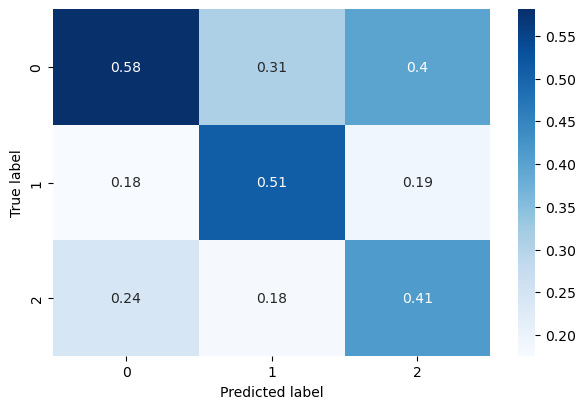

In [131]:
figure = plt.figure(figsize=(6, 4))
sns.heatmap(result, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [132]:
accuracy = metrics.accuracy_score(y_test, y_predict)
precision = metrics.precision_score(y_test, y_predict, average = 'macro')
recall = metrics.recall_score(y_test, y_predict, average = 'micro')
f1 = metrics.f1_score(y_test, y_predict, average = 'weighted')
auc = roc_auc_score(y_test, model.predict(x_test, verbose=0), multi_class='ovr')

print("=============================================")
print("The overall accuracy is:", round(accuracy, 4))
print("The precision score is:", round(precision, 4))
print("The recall score is:", round(recall, 4))
print("The f1 score is:", round(f1, 4))
print("The AUC score is:", round(auc, 4))
print("=============================================")

The overall accuracy is: 0.5052
The precision score is: 0.501
The recall score is: 0.5052
The f1 score is: 0.5076
The AUC score is: 0.6861


***

#### k-fold

In [55]:
x_trainset, x_test, y_trainset, y_test = train_test_split(ori_x, ori_y, test_size = 0.4, random_state = 710674)

In [56]:
x_train, x_vali, y_train, y_vali = train_test_split(x_trainset, y_trainset, test_size = 0.2, random_state = 710674)

In [59]:
inputs = np.concatenate((x_train, x_vali), axis = 0)
targets = np.concatenate((y_train, y_vali), axis = 0)

In [60]:
fold_num = 1
split_num = 5
opt = keras.optimizers.SGD(learning_rate = args.lr, decay = 1e-6, momentum = args.momentum)
kfold = KFold(n_splits = split_num, shuffle = True)

In [61]:
############## FOR balanced CLASSIFICATION ###############
class_weight = {0:1, 1:1.3, 2: 1.43} ## con 194, pd 149, mdd 136

In [62]:
acc_per_fold = []
loss_per_fold = []

In [63]:
x_train.shape

(229, 78)

In [64]:
x_train.columns

Index(['b1SDNN', 'b1NN50', 'b1PNN50', 'b1RMSSD', 'b1VLF', 'b1LF', 'b1HF',
       'b1LF/HF', 'b1POWER', 'b1HR', 'b1RESP', 'b1SC', 'b1TEMP', 'sSDNN',
       'sNN50', 'sPNN50', 'sRMSSD', 'sVLF', 'sLF', 'sHF', 'sLF/HF', 'sPOWER',
       'sHR', 'sRESP', 'sSC', 'sTEMP', 'b2SDNN', 'b2NN50', 'b2PNN50',
       'b2RMSSD', 'b2VLF', 'b2LF', 'b2HF', 'b2LF/HF', 'b2POWER', 'b2HR',
       'b2RESP', 'b2SC', 'b2TEMP', 'rSDNN', 'rNN50', 'rPNN50', 'rRMSSD',
       'rVLF', 'rLF', 'rHF', 'rLF/HF', 'rPOWER', 'rHR', 'rRESP', 'rSC',
       'rTEMP', 'b3SDNN', 'b3NN50', 'b3PNN50', 'b3RMSSD', 'b3VLF', 'b3LF',
       'b3HF', 'b3LF/HF', 'b3POWER', 'b3HR', 'b3RESP', 'b3SC', 'b3TEMP',
       'cSDNN', 'cNN50', 'cPNN50', 'cRMSSD', 'cVLF', 'cLF', 'cHF', 'cLF/HF',
       'cPOWER', 'cHR', 'cRESP', 'cSC', 'cTEMP'],
      dtype='object')

In [65]:
for train, test in kfold.split(inputs, targets):
    model = Sequential()
    model.add(Dense(128, input_dim = x_train.shape[1], activation = 'relu'))
    model.add(Dense(64, activation = 'relu'))
    model.add(BatchNormalization())
    # model.add(Dropout(0.5)) #drop out
    model.add(Dense(32, activation = 'relu'))
    # model.add(Dense(32, activation = 'relu'))
    model.add(Dense(args.num_classes, activation = 'softmax'))
    
    ## model compile
    model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])
    
    print('----------------------------------------')
    print(f'Training or fold {fold_num} ... ')
    
    ## fit data to model
    history = model.fit(inputs[train], targets[train], batch_size = args.bs, epochs = args.epochs, verbose = 0, class_weight = class_weight)
    
    ## generate generalization metrics
    scores = model.evaluate(inputs[test], targets[test])
    print(f'Score for fold {fold_num}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    
    ## increasing fold number
    fold_num = fold_num + 1
    
    
    
## Summarizing the results
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'>> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'>>> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'>>> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

----------------------------------------
Training or fold 1 ... 
2/2 [==============================] - 0s 2ms/step - loss: 1.0899 - accuracy: 0.4138
Score for fold 1: loss of 1.0899096727371216; accuracy of 41.37931168079376%
accuracy: 41.38%
----------------------------------------
Training or fold 2 ... 
2/2 [==============================] - 0s 3ms/step - loss: 1.1119 - accuracy: 0.3103
Score for fold 2: loss of 1.111851453781128; accuracy of 31.034481525421143%
accuracy: 31.03%
----------------------------------------
Training or fold 3 ... 
2/2 [==============================] - 0s 3ms/step - loss: 1.2685 - accuracy: 0.3509
Score for fold 3: loss of 1.2685484886169434; accuracy of 35.087719559669495%
accuracy: 35.09%
----------------------------------------
Training or fold 4 ... 
2/2 [==============================] - 0s 3ms/step - loss: 1.0941 - accuracy: 0.4561
Score for fold 4: loss of 1.0940521955490112; accuracy of 45.614033937454224%
accuracy: 45.61%
----------------------

In [66]:
y_predict = model.predict(x_test)
y_predict = np.argmax(y_predict, axis = 1)
y_test = np.argmax(y_test, axis = 1)

result = confusion_matrix(y_test, y_predict, normalize = 'pred')
print(result)

6/6 [==============================] - 0s 1ms/step
[[0.43093923 0.7        0.        ]
 [0.28729282 0.         1.        ]
 [0.28176796 0.3        0.        ]]


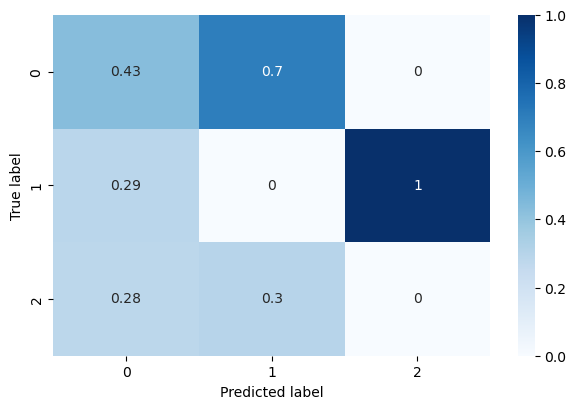

In [67]:
figure = plt.figure(figsize=(6, 4))
sns.heatmap(result, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [68]:
accuracy = metrics.accuracy_score(y_test, y_predict)
precision = metrics.precision_score(y_test, y_predict, average = 'macro')
recall = metrics.recall_score(y_test, y_predict, average = 'micro')
f1 = metrics.f1_score(y_test, y_predict, average = 'weighted')

print("=============================================")
print("The overall accuracy is:", round(accuracy, 4))
print("The precision score is:", round(precision, 4))
print("The recall score is:", round(recall, 4))
print("The f1 score is:", round(f1, 4))
print("=============================================")

The overall accuracy is: 0.4062
The precision score is: 0.1436
The recall score is: 0.4062
The f1 score is: 0.2596


***

#### 1D-Conv

In [176]:
x_train, x_test, y_train, y_test = train_test_split(ori_x, ori_y, test_size = 0.4, random_state = 710674)

In [177]:
x_train.shape

(287, 78)

In [178]:
# Build the 1D CNN model
model = Sequential()
# 1st Convolutional Layer
model.add(Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=3))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=3))

# Flatten the output and add Dense layers
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
# model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dense(args.num_classes, activation='softmax'))

In [179]:
opt = keras.optimizers.SGD(learning_rate = args.lr, decay = 1e-5, momentum = args.momentum)

In [180]:
# LearningRateScheduler 설정
lr_scheduler = LearningRateScheduler(lambda epoch: cyclic_learning_rate(epoch, base_lr=0.01, max_lr=0.006, step_size=300))
# lr_scheduler = LearningRateScheduler(lambda epoch: exp_range_lr(epoch, base_lr=0.01, max_lr=0.006, step_size=300, gamma=0.99994))

In [181]:
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
# history = model.fit(x_train, y_train, epochs=args.epochs, batch_size=args.bs, verbose=2)   ## using no class weight
# history = model.fit(x_train, y_train, epochs=args.epochs, batch_size=args.bs, verbose=2, class_weight = class_weight)  ## using class weight
history = model.fit(x_train, y_train, epochs=args.epochs, batch_size=args.bs, callbacks=[lr_scheduler], class_weight = class_weight, verbose=2) ## using LR scheduler callback

Epoch 1/300
9/9 - 1s - loss: 1.3732 - accuracy: 0.3380 - lr: 0.0100 - 514ms/epoch - 57ms/step
Epoch 2/300
9/9 - 0s - loss: 1.2886 - accuracy: 0.3937 - lr: 0.0100 - 99ms/epoch - 11ms/step
Epoch 3/300
9/9 - 0s - loss: 1.2150 - accuracy: 0.5122 - lr: 0.0100 - 102ms/epoch - 11ms/step
Epoch 4/300
9/9 - 0s - loss: 1.1563 - accuracy: 0.5366 - lr: 0.0100 - 52ms/epoch - 6ms/step
Epoch 5/300
9/9 - 0s - loss: 1.1289 - accuracy: 0.5923 - lr: 0.0099 - 33ms/epoch - 4ms/step
Epoch 6/300
9/9 - 0s - loss: 1.0891 - accuracy: 0.5958 - lr: 0.0099 - 34ms/epoch - 4ms/step
Epoch 7/300
9/9 - 0s - loss: 1.0551 - accuracy: 0.6272 - lr: 0.0099 - 35ms/epoch - 4ms/step
Epoch 8/300
9/9 - 0s - loss: 1.0194 - accuracy: 0.6132 - lr: 0.0099 - 34ms/epoch - 4ms/step
Epoch 9/300
9/9 - 0s - loss: 0.9473 - accuracy: 0.6969 - lr: 0.0099 - 36ms/epoch - 4ms/step
Epoch 10/300
9/9 - 0s - loss: 0.8909 - accuracy: 0.7073 - lr: 0.0099 - 32ms/epoch - 4ms/step
Epoch 11/300
9/9 - 0s - loss: 0.8952 - accuracy: 0.7108 - lr: 0.0099 - 34m

***

In [182]:
y_predict = model.predict(x_test)
y_predict = np.argmax(y_predict, axis = 1)
y_test = np.argmax(y_test, axis = 1)

result = confusion_matrix(y_test, y_predict, normalize = 'pred')
print(result)

6/6 [==============================] - 0s 6ms/step
[[0.6440678  0.28571429 0.42857143]
 [0.11864407 0.45714286 0.22222222]
 [0.23728814 0.25714286 0.34920635]]


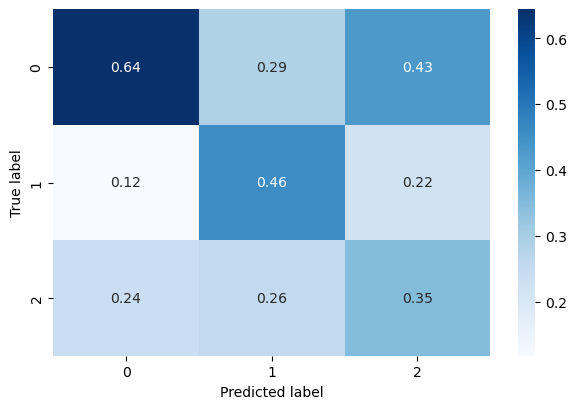

In [183]:
figure = plt.figure(figsize=(6, 4))
sns.heatmap(result, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [184]:
accuracy = metrics.accuracy_score(y_test, y_predict)
precision = metrics.precision_score(y_test, y_predict, average = 'macro')
recall = metrics.recall_score(y_test, y_predict, average = 'micro')
f1 = metrics.f1_score(y_test, y_predict, average = 'weighted')
auc = roc_auc_score(y_test, model.predict(x_test, verbose=0), multi_class='ovr')

print("=============================================")
print("The overall accuracy is:", round(accuracy, 4))
print("The precision score is:", round(precision, 4))
print("The recall score is:", round(recall, 4))
print("The f1 score is:", round(f1, 4))
print("The AUC score is:", round(auc, 4))
print("=============================================")

The overall accuracy is: 0.4792
The precision score is: 0.4835
The recall score is: 0.4792
The f1 score is: 0.4831
The AUC score is: 0.6807


***

***

## Using VAE/AE as a dimensionality reduction

In [ ]:
x = data_x
y = y

In [ ]:
class Args:
    # arugments
    epochs=200
    enc_epochs = 50
    bs=32
    enc_bs = 16
    lr=0.001
    momentum=0.9
    encoding_dim = 16
    num_classes= 2
    verbose='store_true'
    seed=710674

args = Args()

### Autoencoder for dim reduction

In [ ]:
# input dataset layer
input_layer = Input(shape=(x.shape[1],))

# encoder layers
encoder = Dense(64, activation='relu')(input_layer)
encoder = Dense(32, activation='relu')(encoder)
encoder_out = Dense(args.encoding_dim, activation='relu')(encoder)

# decoder layers
decoder = Dense(32, activation='relu')(encoder_out)
decoder = Dense(64, activation='relu')(decoder)
decoder_out = Dense(x.shape[1], activation='sigmoid')(decoder)

In [ ]:
# AE model
autoencoder = Model(inputs=input_layer, outputs=decoder_out)

# Encoder model (convert input dataset into latent space)
encoder_model = Model(inputs=input_layer, outputs=encoder_out)

# Decoder model (recover latent space/vector into original dataset format)
encoded_input = Input(shape=(args.encoding_dim,))
decoder_layer = autoencoder.layers[-3](encoded_input)
decoder_layer = autoencoder.layers[-2](decoder_layer)
decoder_out = autoencoder.layers[-1](decoder_layer)
decoder_model = Model(inputs=encoded_input, outputs=decoder_layer)

In [ ]:
# Model compile
autoencoder.compile(optimizer='adam', loss='mse')

# Checking each model
autoencoder.summary()
# encoder_model.summary()
# decoder_model.summary()

In [ ]:
## Model training
autoencoder.fit(x, x, epochs = args.enc_epochs, batch_size = args.enc_bs, shuffle=True, validation_split=0.2, verbose=2)

In [ ]:
encoded_data = encoder_model.predict(x)
decoded_data = decoder_model.predict(encoded_data)

In [ ]:
encoded_data.shape

In [ ]:
decoded_data.shape

In [ ]:
y.shape

In [ ]:
decoded_data

In [ ]:
class Args:
    # arugments
    epochs=200
    bs=32
    lr=0.001
    momentum=0.9
    num_classes= 2
    verbose='store_true'
    seed=710674

args = Args()

# np.random.seed(args.seed)
# random.seed(args.seed)
# torch.manual_seed(args.seed)

In [ ]:
x_trainset, x_test, y_trainset, y_test = train_test_split(decoded_data, y, test_size = 0.1, random_state = 710674)
x_train, x_vali, y_train, y_vali = train_test_split(x_trainset, y_trainset, test_size = 0.2, random_state = 710674)

In [ ]:
inputs = np.concatenate((x_train, x_vali), axis = 0)
targets = np.concatenate((y_train, y_vali), axis = 0)

In [ ]:
fold_num = 1
split_num = 5
opt = keras.optimizers.SGD(learning_rate = args.lr, decay = 1e-6, momentum = args.momentum)
kfold = KFold(n_splits = split_num, shuffle = True)
# kfold = StratifiedKFold(n_splits = split_num, shuffle = True)

In [ ]:
############## FOR FOUR-GROUP CLASSIFICATION ###############
class_weight = {0:1, 1: 1.68}

In [ ]:
acc_per_fold = []
loss_per_fold = []

In [ ]:
for train, test in kfold.split(inputs, targets):
    model = Sequential()
    model.add(Dense(128, input_dim = x_train.shape[1], activation = 'relu'))
    model.add(Dense(64, activation = 'relu'))
    model.add(Dropout(0.5)) #drop out
    model.add(Dense(32, activation = 'relu'))
    model.add(Dense(args.num_classes, activation = 'softmax'))
    
    ## model compile
    model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])
    
    print('----------------------------------------')
    print(f'Training or fold {fold_num} ... ')
    
    ## fit data to model
    history = model.fit(inputs[train], targets[train], batch_size = args.bs, epochs = args.epochs, verbose = 0, class_weight = class_weight)
    
    ## generate generalization metrics
    scores = model.evaluate(inputs[test], targets[test])
    print(f'Score for fold {fold_num}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    
    ## increasing fold number
    fold_num = fold_num + 1
    
    
    
## Summarizing the results
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'>> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'>>> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'>>> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

In [ ]:
y_predict = model.predict(x_test)
y_predict = np.argmax(y_predict, axis = 1)
y_test = np.argmax(y_test, axis = 1)

result = confusion_matrix(y_test, y_predict, normalize = 'pred')
print(result)

In [ ]:
figure = plt.figure(figsize=(6, 4))
sns.heatmap(result, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
accuracy = metrics.accuracy_score(y_test, y_predict)
precision = metrics.precision_score(y_test, y_predict, average = 'macro')
recall = metrics.recall_score(y_test, y_predict, average = 'micro')
f1 = metrics.f1_score(y_test, y_predict, average = 'weighted')
auc = roc_auc_score(y_test, model.predict(x_test, verbose=0), multi_class='ovr')

print("=============================================")
print("The overall accuracy is:", round(accuracy, 4))
print("The precision score is:", round(precision, 4))
print("The recall score is:", round(recall, 4))
print("The f1 score is:", round(f1, 4))
print("The AUC score is:", round(auc, 4))
print("=============================================")